In [1]:
# The Code written by Ali Babolhaveji @ 5/30/2020


dataPath = "../../data"

In [43]:
import os
import pandas as pd


metaData = os.path.join(dataPath,'train_metadata.csv')
df = pd.DataFrame(os.listdir(os.path.join(dataPath,'video')) , columns=['vid_name'])
pd.read_csv(metaData)

,filename,url,project_id,num_frames,crowd_score,tier1,micro,nano
0,100000.mp4,s3://drivendata-competition-clog-loss/train/10...,M,54,0.000000,True,False,False
1,100001.mp4,s3://drivendata-competition-clog-loss/train/10...,F,48,0.022769,False,False,False
2,100002.mp4,s3://drivendata-competition-clog-loss/train/10...,H,122,0.000000,True,False,False
3,100003.mp4,s3://drivendata-competition-clog-loss/train/10...,E,55,0.000000,True,False,False
4,100004.mp4,s3://drivendata-competition-clog-loss/train/10...,C,56,0.000000,True,False,False
...,...,...,...,...,...,...,...,...
573043,687207.mp4,s3://drivendata-competition-clog-loss/train/68...,G,93,0.000000,True,False,False
573044,687208.mp4,s3://drivendata-competition-clog-loss/train/68...,A,60,0.000000,True,False,False
573045,687209.mp4,s3://drivendata-competition-clog-loss/train/68...,E,49,0.000000,True,False,False
573046,687210.mp4,s3://drivendata-competition-clog-loss/train/68...,D,42,0.151080,False,False,False


In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import ipyvolume as ipv

def filter_image(image ,area):
    xmin , xmax,ymin , ymax = area
#     image =  cv2.rectangle(image , (xmin,ymin) ,(xmax,ymax),(255,255,255),4,4)
    image = image[ ymin:ymax , xmin:xmax ]
    image = cv2.resize(image ,(150,150))
    image = image /255.
#     image -= image.mean()
#     image /= image.std()
#     print(image.shape , xmin , xmax,ymin , ymax)
    
    
    return image

def get_specified_area(image):
    
    # convert to hsv to detect the outlined orange area
    hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    lower_red = np.array([100,120,150])
    upper_red = np.array([110,255,255])
    # create a mask
    mask1 = cv2.inRange(hsv, lower_red, upper_red)
    mask1 = cv2.dilate(mask1, None, iterations=2)
    mask_ind = np.where(mask1>0)
    xmin , xmax = min(mask_ind[1]) , max(mask_ind[1])
    ymin , ymax = min(mask_ind[0]) , max(mask_ind[0])
    # remove orange line from the image
    image[mask_ind ]=0,0,0
    # fill the area to skip the data outside of this area
    ret,mask1 = cv2.threshold(mask1,10,255,cv2.THRESH_BINARY_INV)
    contours,hierarchy = cv2.findContours(mask1, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    contours = [ctr for ctr in contours if cv2.contourArea(ctr) < 5*(mask1.shape[0]*mask1.shape[1])/6]
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    cv2.drawContours(mask1, [contours[-1]], -1, (0, 0, 0), -1)
    # remove data out of the outlined area
    image[mask1>0] = (0,0,0)

    return image ,(xmin , xmax , ymin , ymax)
    


def getFrame( vidcap , sec , image_name ):
        vidcap.set(cv2.CAP_PROP_POS_MSEC, sec * 1000)
        hasFrames,image = vidcap.read()
        if(hasFrames):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image ,hasFrames
    
def draw_tensor(tensor_img):

    ipv.figure()
    ipv.volshow(tensor_img[...,2], level=[0.41, 0.75], opacity=0.5, level_width=0.1, data_min=0, data_max=1)
    ipv.view(-30, 40)
    ipv.show()
    

    

from_sec = 0
step = 1.

vid = df.iloc[11]['vid_name']
vidcap = cv2.VideoCapture(os.path.join(dataPath,'video',vid))
total_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
frame_size = (int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH)) , int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT )))
fps = vidcap.get(cv2.CAP_PROP_FPS)
Video_len = total_frames / fps

# total_frames =5
time_stamp = np.linspace(from_sec , Video_len , int(total_frames / step) )

sec = 0 
frame_num = 1
img_cv2 , hasframe = getFrame(vidcap ,sec , frame_num)

print(total_frames-1,frame_size, fps ,Video_len,time_stamp)

# tensor_img = np.zeros((int(total_frames) ,384,512,3))
tensor_img = []
for frame in range(int(total_frames)):

    image , hasframe = getFrame(vidcap ,time_stamp[frame] , frame)
#     print(frame ,hasframe)
    if hasframe:
        if frame==0:
            image , area = get_specified_area(image)
        else:
            image , _ = get_specified_area(image)
        image = filter_image(image , area)
        tensor_img.append(image)
#     tensor_img[frame] ,_ = getFrame(vidcap ,time_stamp[frame] , frame)
tensor_img = np.array(list(tensor_img))

print(tensor_img.shape)
draw_tensor(tensor_img)


85.0 (512, 384) 15.0 5.733333333333333 [0.         0.06745098 0.13490196 0.20235294 0.26980392 0.3372549
 0.40470588 0.47215686 0.53960784 0.60705882 0.6745098  0.74196078
 0.80941176 0.87686275 0.94431373 1.01176471 1.07921569 1.14666667
 1.21411765 1.28156863 1.34901961 1.41647059 1.48392157 1.55137255
 1.61882353 1.68627451 1.75372549 1.82117647 1.88862745 1.95607843
 2.02352941 2.09098039 2.15843137 2.22588235 2.29333333 2.36078431
 2.42823529 2.49568627 2.56313725 2.63058824 2.69803922 2.7654902
 2.83294118 2.90039216 2.96784314 3.03529412 3.1027451  3.17019608
 3.23764706 3.30509804 3.37254902 3.44       3.50745098 3.57490196
 3.64235294 3.70980392 3.7772549  3.84470588 3.91215686 3.97960784
 4.04705882 4.1145098  4.18196078 4.24941176 4.31686275 4.38431373
 4.45176471 4.51921569 4.58666667 4.65411765 4.72156863 4.78901961
 4.85647059 4.92392157 4.99137255 5.05882353 5.12627451 5.19372549
 5.26117647 5.32862745 5.39607843 5.46352941 5.53098039 5.59843137
 5.66588235 5.73333333]
(

In [4]:
# import ipyvolume as ipv
# ipv.figure()

# ipv.volshow(tensor_img[...,1], level=[0.41, 0.75], opacity=0.5, level_width=0.1, data_min=0, data_max=255)
# ipv.view(-30, 40)
# ipv.show()

# #levels 0.41 ,0.47 ,0.76
# # opa 0.14 .0.11 ,0.11

# # op=12.6 , brith= 2.00

In [11]:
df

,vid_name
0,100109.mp4
1,100289.mp4
2,100588.mp4
3,100750.mp4
4,102393.mp4
...,...
1408,684243.mp4
1409,684329.mp4
1410,684600.mp4
1411,684744.mp4


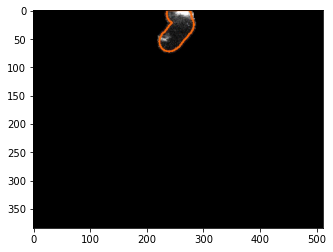

In [49]:
image , hasframe = getFrame(vidcap ,time_stamp[0] , 0)
hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
lower_red = np.array([100,120,150])
upper_red = np.array([110,255,255])
mask1 = cv2.inRange(hsv, lower_red, upper_red)

mask1 = cv2.dilate(mask1, None, iterations=2)
mask_ind = np.where(mask1>0)
xmin , xmax = min(mask_ind[1]) , max(mask_ind[1])
ymin , ymax = min(mask_ind[0]) , max(mask_ind[0])



ret,mask1 = cv2.threshold(mask1,10,255,cv2.THRESH_BINARY_INV)
contours,hierarchy = cv2.findContours(mask1, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

contours = [ctr for ctr in contours if cv2.contourArea(ctr) < 5*(mask1.shape[0]*mask1.shape[1])/6]
contours = sorted(contours, key=cv2.contourArea, reverse=True)
# for ctr in contours:
#     print(cv2.contourArea(ctr), 5*(mask1.shape[0]*mask1.shape[1])/6)

cv2.drawContours(mask1, [contours[0]], -1, (0, 0, 0), -1)
image[mask1>0] = (0,0,0)
plt.imshow(image)


In [5]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import copy

gray = cv2.cvtColor(img_cv2 , cv2.COLOR_BGR2GRAY)


def plot_func(val ):
    img_cv2 , hasframe = getFrame(vidcap ,sec , frame_num)
    hsv = cv2.cvtColor(img_cv2,cv2.COLOR_BGR2HSV)
    
    lower_red = np.array([100,120,150])
    upper_red = np.array([110,255,255])
    mask1 = cv2.inRange(hsv, lower_red, upper_red)
    
#     img = Image.fromarray(img)
#     enhancer  = ImageEnhance.Contrast(img)
#     img = enhancer.enhance(val)
#     enhancer  = ImageEnhance.Brightness(img)
#     img = enhancer.enhance(val_b)
#     img = np.hstack((hsv ,mask1))
    plt.figure(figsize=(10,10))
    plt.imshow(mask1)
    
interact(plot_func, val = widgets.FloatSlider(value=120,
                                               min=0,
                                               max=255,
                                               step=5) )

# newRet, binaryThreshold = cv2.threshold(hsv,127,255,cv2.THRESH_BINARY_INV)
# img_gray = cv2.cvtColor(hsv, cv2.COLOR_BGR2GRAY)

# ret, thresh = cv2.threshold(img_gray,20,255,0)
# contours, heirarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# cont_sort = sorted(contours, key=cv2.contourArea, reverse=True)
# cv2.drawContours(img_cv2, cont_sort[1], -1, (0, 255, 0), 2)

ms

interactive(children=(FloatSlider(value=120.0, description='val', max=255.0, step=5.0), Output()), _dom_classe…

NameError: name 'ms' is not defined

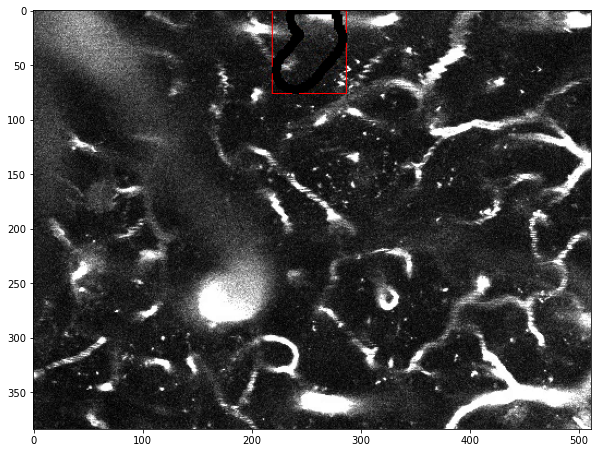

In [50]:
img_cv2 , hasframe = getFrame(vidcap ,sec , frame_num)
hsv = cv2.cvtColor(img_cv2,cv2.COLOR_BGR2HSV)

lower_red = np.array([100,120,150])
upper_red = np.array([110,255,255])
mask1 = cv2.inRange(hsv, lower_red, upper_red)

#     img = Image.fromarray(img)
#     enhancer  = ImageEnhance.Contrast(img)
#     img = enhancer.enhance(val)
#     enhancer  = ImageEnhance.Brightness(img)
#     img = enhancer.enhance(val_b)
#     img = np.hstack((hsv ,mask1))

mask1 = cv2.dilate(mask1, None, iterations=2)
# mask1 = cv2.erode (mask1, None, iterations=1)

mask_ind = np.where(mask1>0)


max(mask_ind[0])

xmin , xmax = min(mask_ind[1]) , max(mask_ind[1])
ymin , ymax = min(mask_ind[0]) , max(mask_ind[0])

img_cv2 =  cv2.rectangle(img_cv2 , (xmin,ymin) ,(xmax,ymax),(255,0,0),1,1)
img_cv2[mask_ind ]=0
plt.figure(figsize=(10,10))
plt.imshow(img_cv2)

### Extract important data from specific area

27 4 56 14
9 46 21 54


[[27, 4, 56, 14, 149.5], [9, 46, 21, 54, 41.5]]

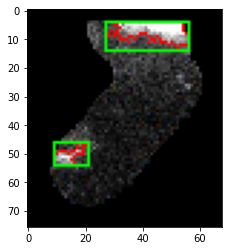

In [112]:
image , hasframe = getFrame(vidcap ,sec , frame_num)

# convert to hsv to detect the outlined orange area
hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
lower_red = np.array([100,120,150])
upper_red = np.array([110,255,255])
# create a mask
mask1 = cv2.inRange(hsv, lower_red, upper_red)
mask1 = cv2.dilate(mask1, None, iterations=2)
mask_ind = np.where(mask1>0)
xmin , xmax = min(mask_ind[1]) , max(mask_ind[1])
ymin , ymax = min(mask_ind[0]) , max(mask_ind[0])
# remove orange line from the image
image[mask_ind ]=0,0,0
# fill the area to skip the data outside of this area
ret,mask1 = cv2.threshold(mask1,10,255,cv2.THRESH_BINARY_INV)
contours,hierarchy = cv2.findContours(mask1, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
contours = [ctr for ctr in contours if cv2.contourArea(ctr) < 5*(mask1.shape[0]*mask1.shape[1])/6]
contours = sorted(contours, key=cv2.contourArea, reverse=True)
cv2.drawContours(mask1, [contours[-1]], -1, (0, 0, 0), -1)
# remove data out of the outlined area
image[mask1>0] = (0,0,0)

image = image[ ymin:ymax , xmin:xmax ]


mask2 = cv2.cvtColor(image , cv2.COLOR_RGB2GRAY)
ret,mask2 = cv2.threshold(mask2,100,255,cv2.THRESH_BINARY)

contours,hierarchy = cv2.findContours(mask2, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
# contours = [ctr for ctr in contours if cv2.contourArea(ctr) < 5*(mask1.shape[0]*mask1.shape[1])/6]
contours = sorted(contours, key=cv2.contourArea, reverse=True)

areas = []
for ctr in contours:
    if cv2.contourArea(ctr) > 5:

        cv2.drawContours(image, [ctr], -1, (255, 0, 0), 1)
        xxmin , xxmax = min(ctr[:,:,0])[0] , max(ctr[:,:,0])[0]
        yymin , yymax = min(ctr[:,:,1])[0] , max(ctr[:,:,1])[0]
        
        image = cv2.rectangle(image , (xxmin ,yymin) ,(xxmax , yymax),(0,255,0),1,1)
        areas.append([xxmin ,yymin ,xxmax ,yymax ,cv2.contourArea(ctr) ])
        print(xxmin ,yymin ,xxmax ,yymax)
        


plt.imshow(image)
areas

(150, 150)

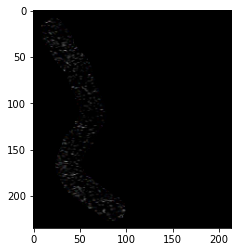

In [208]:
# write the code as function:
image , hasframe = getFrame(vidcap ,sec , frame_num)

def extract_location_area_from_highlighted_curve(image):
    # convert to hsv to detect the outlined orange area
    hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    lower_red = np.array([100,120,150])
    upper_red = np.array([110,255,255])
    # create a mask
    mask1 = cv2.inRange(hsv, lower_red, upper_red)
    mask1 = cv2.dilate(mask1, None, iterations=2)
    mask_ind = np.where(mask1>0)
    xmin , xmax = min(mask_ind[1]) , max(mask_ind[1])
    ymin , ymax = min(mask_ind[0]) , max(mask_ind[0])
    # remove orange line from the image
    image[mask_ind ]=0,0,0
    # fill the area to skip the data outside of this area
    ret,mask1 = cv2.threshold(mask1,10,255,cv2.THRESH_BINARY_INV)
    contours,hierarchy = cv2.findContours(mask1, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    contours = [ctr for ctr in contours if cv2.contourArea(ctr) < 5*(mask1.shape[0]*mask1.shape[1])/6]
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    cv2.drawContours(mask1, [contours[-1]], -1, (0, 0, 0), -1)
    # remove data out of the outlined area
    image[mask1>0] = (0,0,0)

    image = image[ ymin:ymax , xmin:xmax ]


    mask2 = cv2.cvtColor(image , cv2.COLOR_RGB2GRAY)
    ret,mask2 = cv2.threshold(mask2,90,255,cv2.THRESH_BINARY)

    contours,hierarchy = cv2.findContours(mask2, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    # contours = [ctr for ctr in contours if cv2.contourArea(ctr) < 5*(mask1.shape[0]*mask1.shape[1])/6]
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    vessels_image  = np.zeros_like(image)
    

    areas = []
    for ctr in contours:
        if cv2.contourArea(ctr) > 50:

            cv2.drawContours(image, [ctr], -1, (255, 0, 0), -1)
            cv2.drawContours(vessels_image, [ctr], -1, (255, 255, 255), -1)
            
            xxmin , xxmax = min(ctr[:,:,0])[0] , max(ctr[:,:,0])[0]
            yymin , yymax = min(ctr[:,:,1])[0] , max(ctr[:,:,1])[0]

#             image = cv2.rectangle(image , (xxmin ,yymin) ,(xxmax , yymax),(0,255,0),1,1)
            areas.append([xxmin ,yymin ,xxmax ,yymax ,cv2.contourArea(ctr) ])
#             print(xxmin ,yymin ,xxmax ,yymax)
    plt.figure()
    plt.imshow(np.hstack((image,vessels_image)))
    vessels_image = cv2.resize(vessels_image ,(150,150))
    vessels_image = cv2.cvtColor(vessels_image , cv2.COLOR_RGB2GRAY)
    
    
#     area
    return vessels_image 
    
extract_location_area_from_highlighted_curve(image).shape

C:\Users\alibh\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


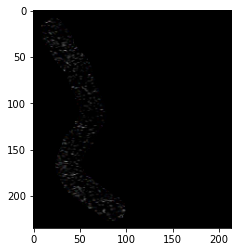

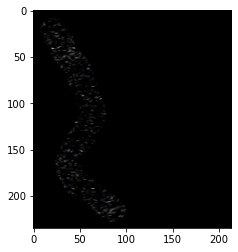

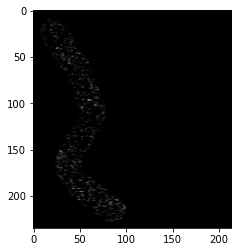

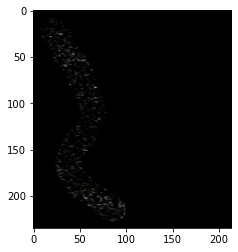

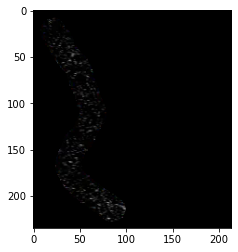

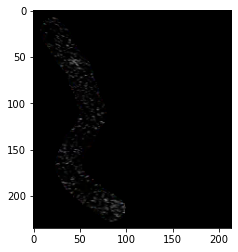

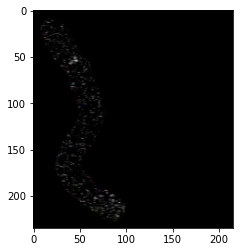

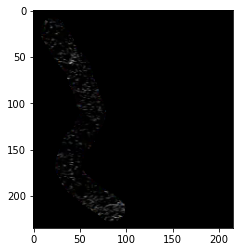

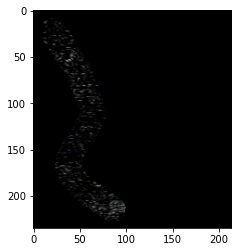

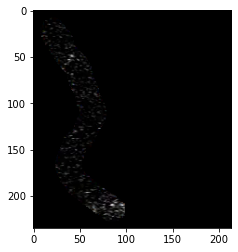

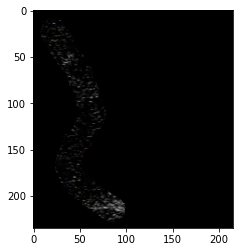

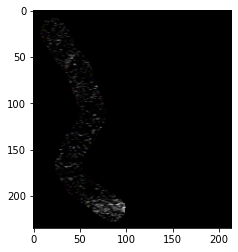

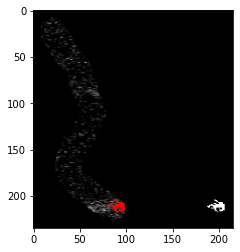

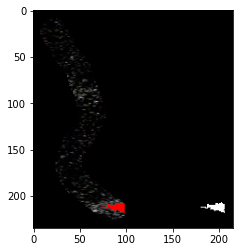

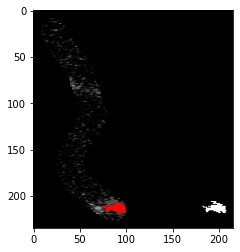

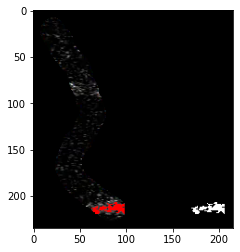

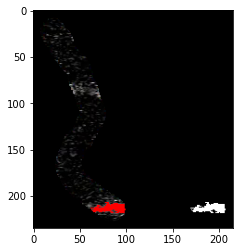

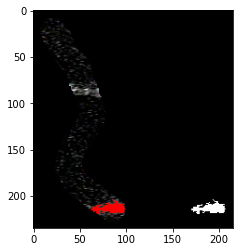

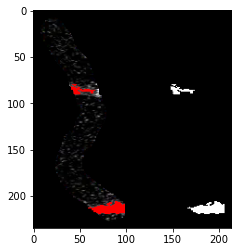

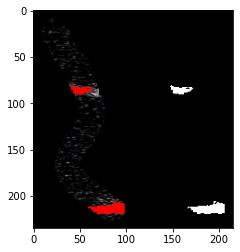

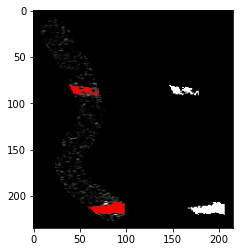

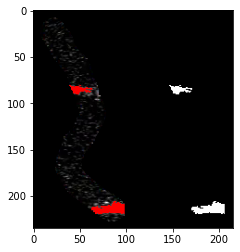

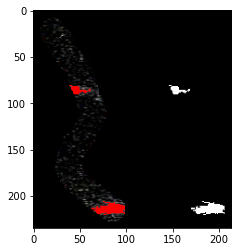

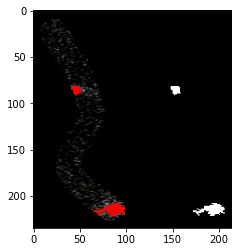

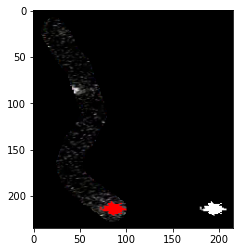

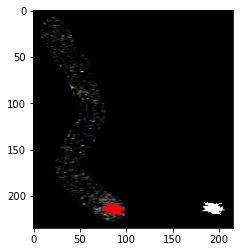

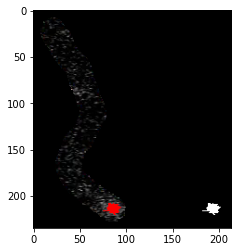

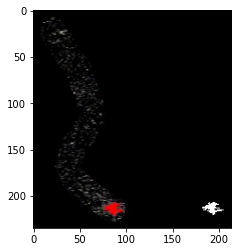

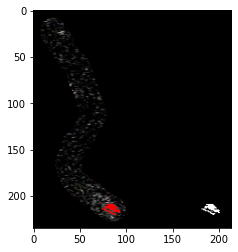

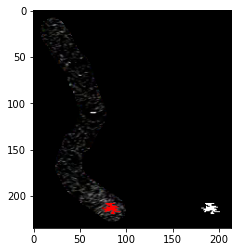

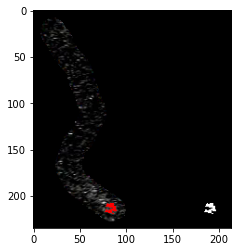

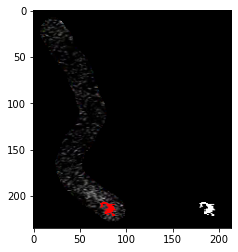

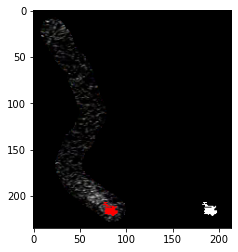

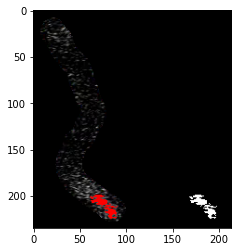

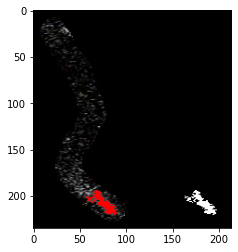

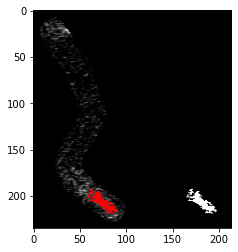

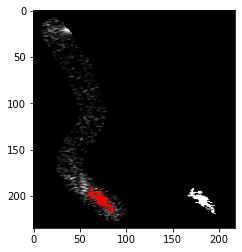

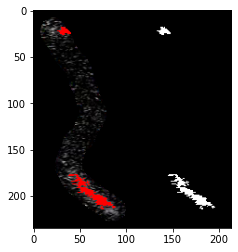

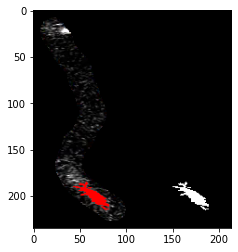

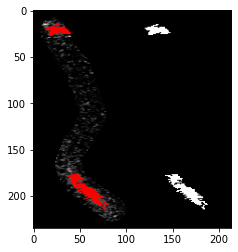

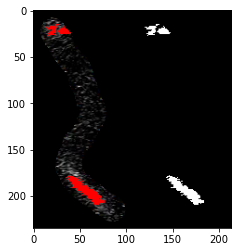

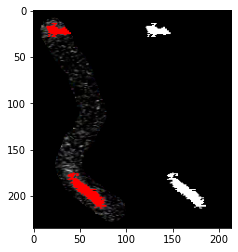

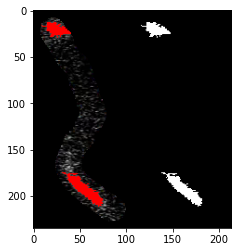

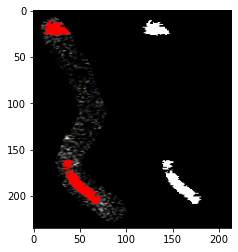

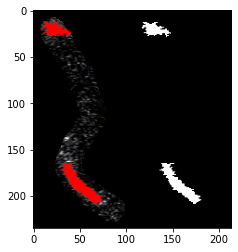

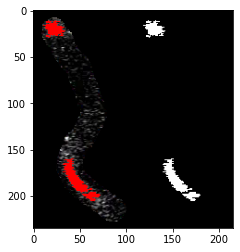

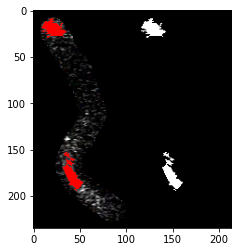

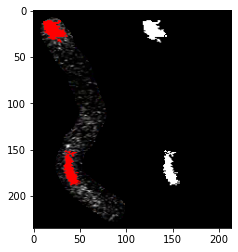

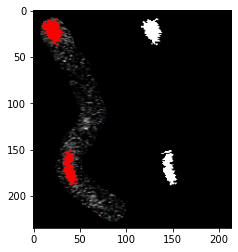

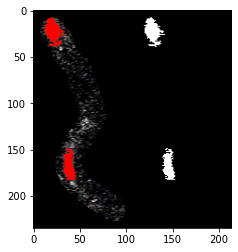

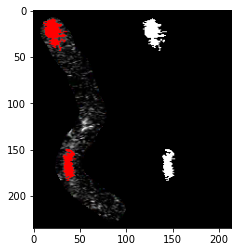

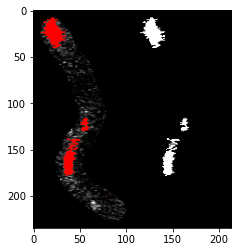

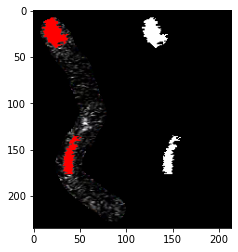

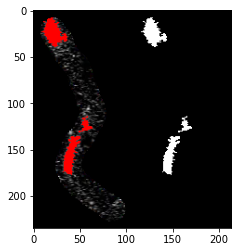

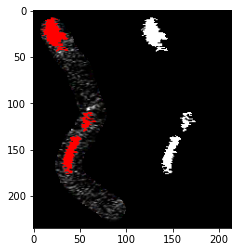

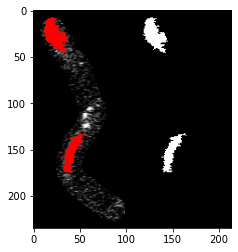

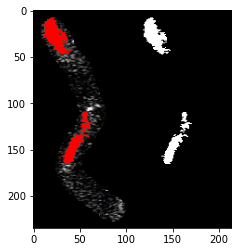

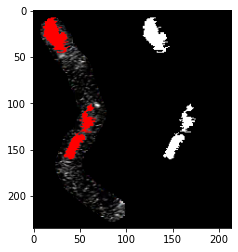

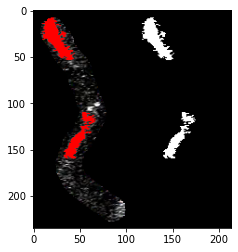

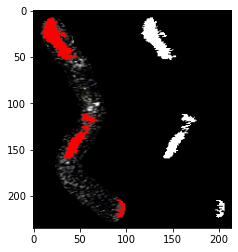

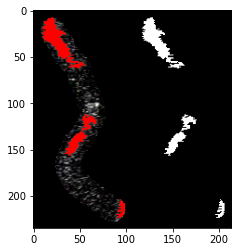

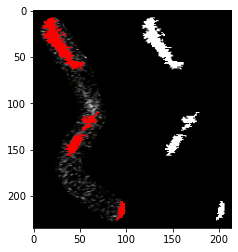

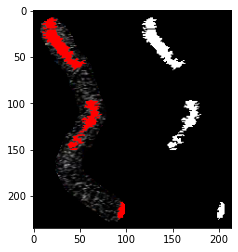

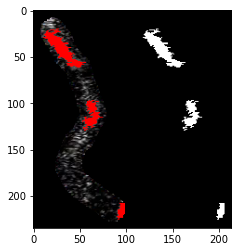

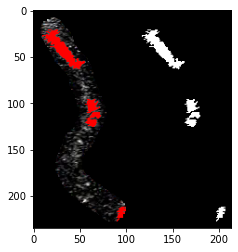

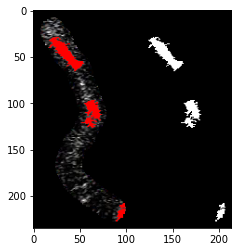

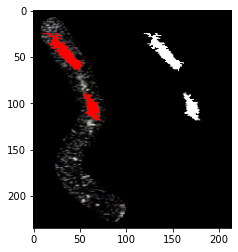

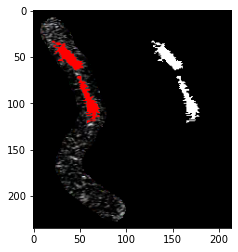

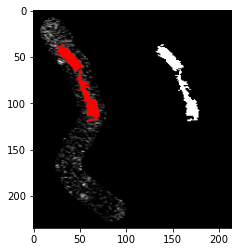

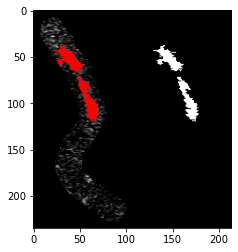

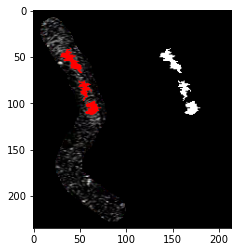

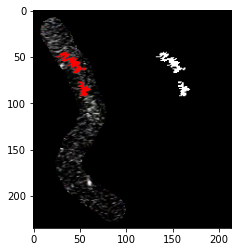

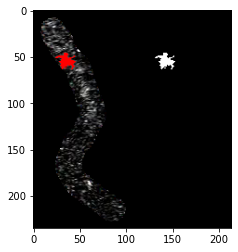

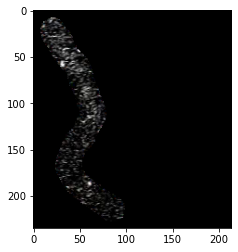

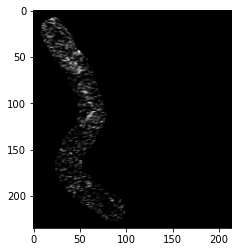

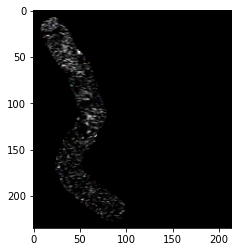

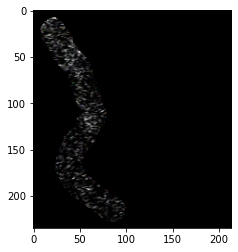

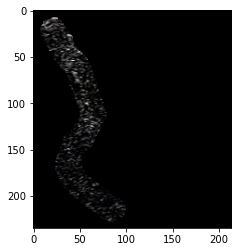

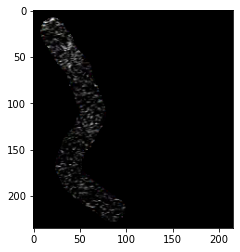

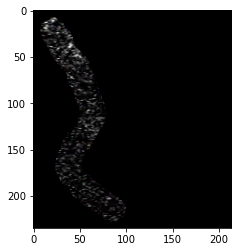

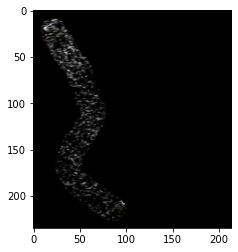

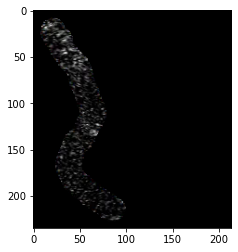

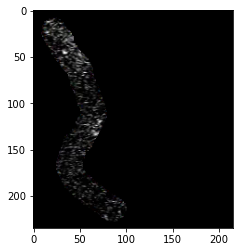

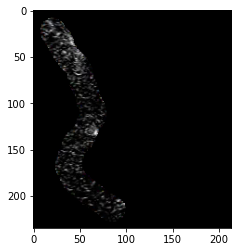

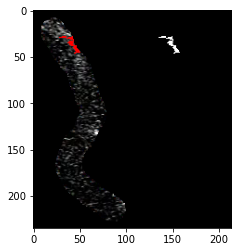

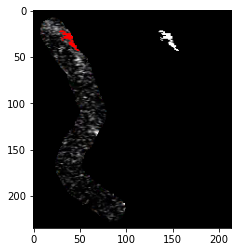

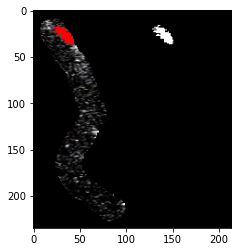

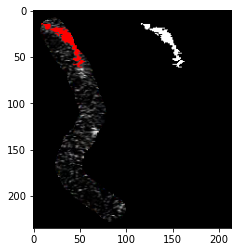

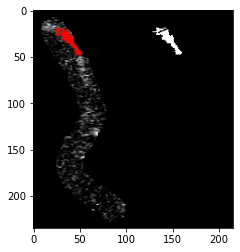

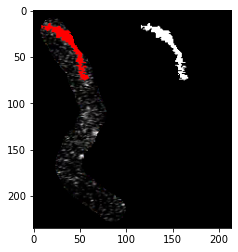

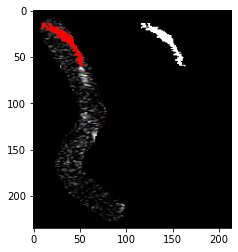

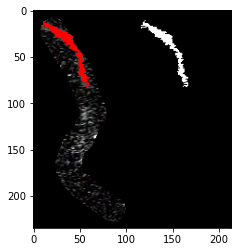

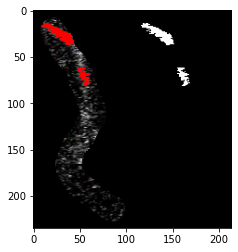

In [209]:
vid = df.iloc[10]['vid_name']
vidcap = cv2.VideoCapture(os.path.join(dataPath,'video',vid))
total_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
frame_size = (int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH)) , int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT )))
fps = vidcap.get(cv2.CAP_PROP_FPS)
Video_len = total_frames / fps

# total_frames =5
time_stamp = np.linspace(from_sec , Video_len , int(total_frames / step) )

sec = 0 
frame_num = 1
img_cv2 , hasframe = getFrame(vidcap ,sec , frame_num)

# print(total_frames-1,frame_size, fps ,Video_len,time_stamp)

# tensor_img = np.zeros((int(total_frames) ,384,512,3))
# tensor_img = []

vessels_tensor = np.zeros([1,150,150])
for frame in range(int(total_frames)):
    image , hasframe = getFrame(vidcap ,time_stamp[frame] , frame)
    if hasframe:
        vessels_image = extract_location_area_from_highlighted_curve(image)
        vessels_tensor =np.append(vessels_tensor ,vessels_image[np.newaxis,...], axis=0)

        
        




In [210]:
def draw_tensor(tensor_img):

    ipv.figure()
#         ipv.volshow(tensor_img[...,0], level=[0.36, 0.55,1], opacity=[0.11,0.13, 0.13], level_width=0.05, data_min=0, data_max=1 ,lighting=True)
    ipv.volshow(tensor_img[...,0], level=[0.36, 0.17,0.36], opacity=[0.05,0.13, 0.10], level_width=0.05, data_min=0, data_max=1 ,lighting=True)

    ipv.view(-30, 45)
    ipv.show()

In [211]:
# vessels_tensor = np.zeros([1,150,150])
# vessels_tensor.shape
# image , hasframe = getFrame(vidcap ,sec , frame_num)
# vessels_image = extract_location_area_from_highlighted_curve(image)
# np.append(vessels_image[np.newaxis,...] ,vessels_tensor,axis=0).shape

print(vessels_tensor.shape)
draw_tensor(vessels_tensor[...,np.newaxis])

(94, 150, 150)


In [101]:
max(contours[0][:,:,0]) , min(contours[0][:,:,0]) ,\
max(contours[0][:,:,1]) , min(contours[0][:,:,1])

(array([56], dtype=int32),
 array([27], dtype=int32),
 array([14], dtype=int32),
 array([4], dtype=int32))

In [54]:
# plt.imshow(mask1 ,cmap='gray')

(76, 68)


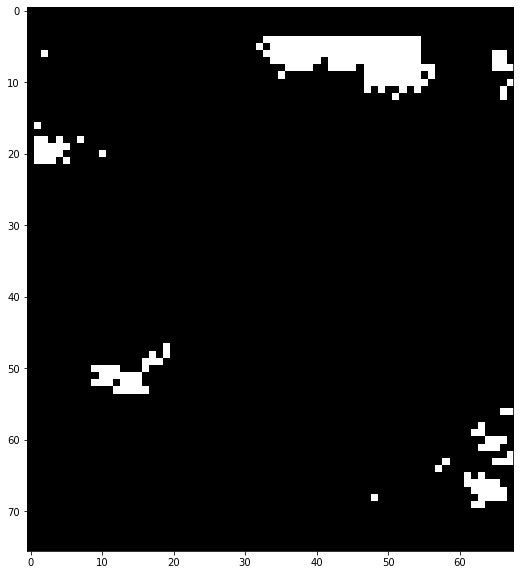

In [39]:





# print(contours)

plt.figure(figsize=(10,10))
plt.imshow(mask1 ,cmap='gray')

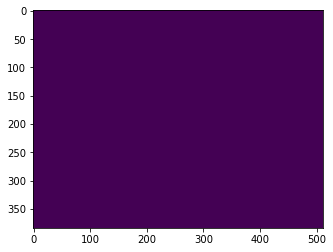

In [7]:
# img_cv2 = cv2.GaussianBlur(img_cv2, (5, 5), 0)
# img_cv2 = cv2.Canny (img_cv2, 50, 100)
# img_cv2 = cv2.dilate(img_cv2, None, iterations=2)
# img_cv2 = cv2.erode (img_cv2, None, iterations=1)
img_gray = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(img_gray,20,255,0)
contours, heirarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cont_sort = sorted(contours, key=cv2.contourArea, reverse=True)
cv2.drawContours(img_cv2, cont_sort[2], -1, (0, 255, 0), 2)
# cv2.drawContours(img_cv2, contours, -1, (127,127,0), 2)

# cnts = cnts[0] if imutils.is_cv2() else cnts[1]
# cnts
# c = max(cnts, key=cv2.contourArea)
hsv = cv2.cvtColor(img_cv2,cv2.COLOR_BGR2HSV)
lower_red = np.array([170,120,70])
upper_red = np.array([180,255,255])
mask1 = cv2.inRange(hsv, lower_red, upper_red)

plt.imshow(mask1)